In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('../'))

from src import lmpc
from src.lmpc.utils import generateRandomSquareMeshLTI, plot_topology_locality

In [2]:
# system params
n = 3           # grid size
Ns = 2          # states per subsystem
Na = 1          # acitons per subsystem
LOCALITY = 1
T = 10          # mpc horizon
Tsim = 40       # scenario sim time
lBound = -0.5   # control input lower bound

# dynamics matrix of random mesh system
A, B = generateRandomSquareMeshLTI(n, seed=2024)
# cost matrices
Q = np.eye(n*n*Ns)
R = np.eye(n*n*Na)

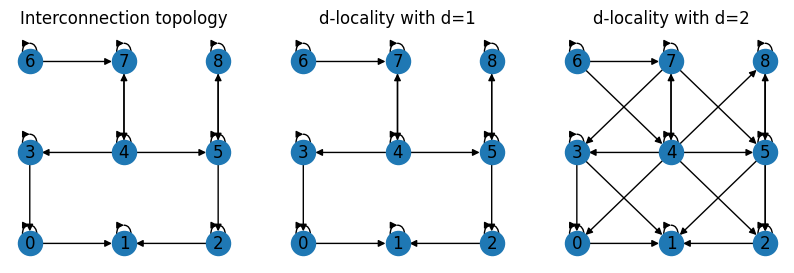

In [3]:
# init system
sys = lmpc.DistributedLTI(n*n, Ns, Na)
sys.loadAB(A, B)
sys << lmpc.dLocality(d=LOCALITY)
plot_topology_locality(sys, n, LOCALITY)

In [4]:
# init controller
controller = lmpc.LMPC(T)
controller << sys

# add objective
controller.addObjectiveFun(lmpc.objectives.QuadForm(Q, R))
# add terminal constraint (= 0 by default)
controller.addConstraint(lmpc.constraints.TerminalConstraint())
# add lower bound to control
controller.addConstraint(lmpc.constraints.BoundConstraint('u', 'lower', lBound*np.ones((sys.Nu,1))))

In [5]:
# scenario
# init condition
x0 = 0.5 * np.ones((sys.Nx, 1))
sys.setInitialState(x0)

# history buffer
cost_history = np.zeros((Tsim))
u_history = np.zeros((Tsim, 1, sys.Nu))
x_history = np.zeros((Tsim+1, 1, sys.Nx))
x_history[0] = x0.T

# run scenrario
for t in range(Tsim):
  u, cost = controller.solve(sys._x)
  x = sys.step(u)
  sys.updateState(x) 
  cost_history[t] = cost
  u_history[t, 0, :] = u.squeeze()
  x_history[t+1, 0, :] = x.squeeze()


Initial cost = 54.917892618261135


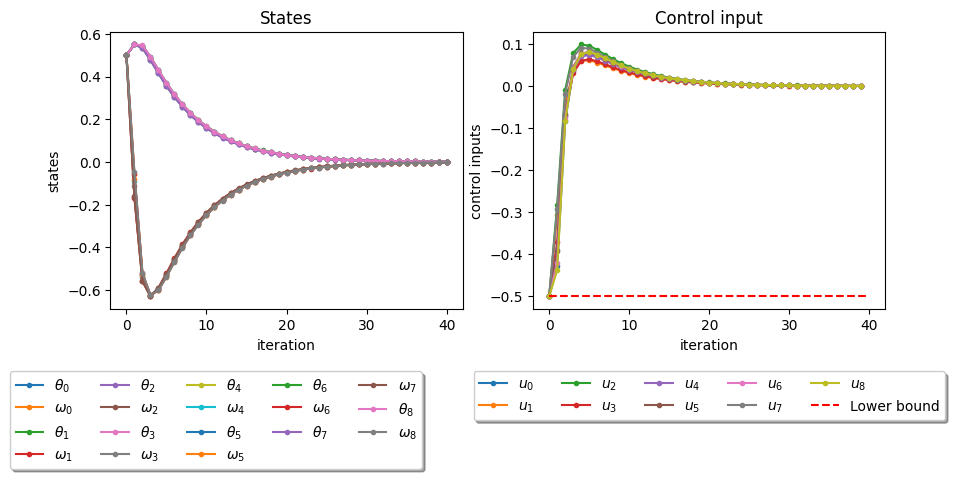

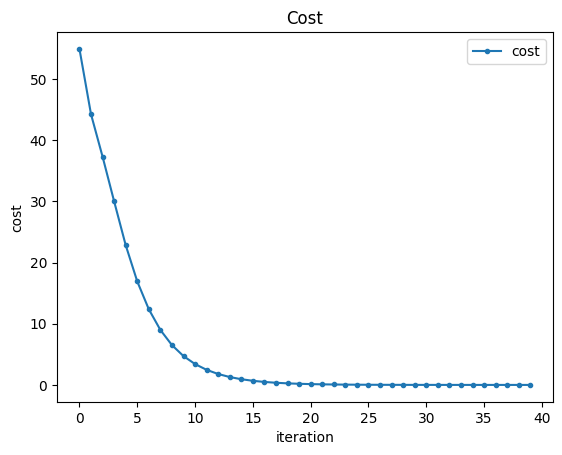

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
for i in range(sys.Nx):
  label = f"$\\theta_{int(i/2)}$" if i%2==0 else f"$\omega_{int((i-1)/2)}$"
  ax[0].plot(np.arange(0, Tsim+1), x_history[:, 0, i], ".-", label=label)
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("states")
ax[0].set_title("States")
# Shrink current axis's height by 10% on the bottom
box = ax[0].get_position()
ax[0].set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax[0].legend(loc='upper center', bbox_to_anchor=(0.3, -0.2),
          fancybox=True, shadow=True, ncol=5)

for i in range(sys.Nu):
  label = f"$u_{i}$"
  ax[1].plot(np.arange(0, Tsim), u_history[:, 0, i], ".-", label=label)
ax[1].hlines(y=lBound, xmin=0, xmax=Tsim, colors='red', linestyles='--', label='Lower bound')
ax[1].set_xlabel("iteration")
ax[1].set_ylabel("control inputs")
ax[1].set_title("Control input")
# Shrink current axis's height by 10% on the bottom
box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5)


plt.figure()
plt.plot(np.arange(0, Tsim), cost_history, ".-", label="cost")
plt.xlabel("iteration")
plt.ylabel("cost")
plt.title("Cost")
plt.legend(loc="best")

print(f"Initial cost = {cost_history[0]}")